In [1]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.nn import Embedding
from tqdm import tqdm
import torch
import torch.nn as nn
import json

# 实体匹配，数据生成

## 构建关系、实体词典

In [2]:
# relation_dict = {}
# with open("./unlabelled_data/relation.txt", "r") as f:
#     for i, relation in enumerate(f.readlines()):
#         relation = relation.strip("\n")
#         relation_dict[relation] = i
# relation_dict

In [61]:
# entity_dict = {}
# with open("./unlabelled_data/entity.txt", "r") as f:
#     for i, entity in enumerate(f.readlines()):
#         entity = entity.strip("\n")
#         entity_dict[entity] = i

id2entity = {}
with open("/kaggle/input/unlabelled-data2/entity.txt", "r") as f:
    for i, entity in enumerate(f.readlines()):
        entity = entity.strip("\n")
        id2entity[i] = entity

id2relation = {}
with open("/kaggle/input/unlabelled-data2/relation.txt", "r") as f:
    for i, relation in enumerate(f.readlines()):
        id2relation[i] = relation

## 构建知识库

In [4]:
# kn_database = []
# with open("./unlabelled_data/kb.txt", "r") as f:
#     for kn in f.readlines():
#         kn = kn.strip().split('\t')
#         kn_database.append({"h": entity_dict[kn[0]],
#                             "t": entity_dict[kn[2]],
#                             "relation": relation_dict[kn[1]],
#                             "sentences": []})

## 通过直接匹配实体词的方式，构建远程监督数据

In [5]:
# train_data = {}
# with open("./unlabelled_data/unlabelled_data.txt", "r") as f:
#     for i, sentence in enumerate(f.readlines()):
#         data = {"sentence": "",
#             "include_entities":[]}
#         for key in entity_dict.keys():
#             if sentence.find(key) > -1:
#                 data["include_entities"].append(key)
#         data["sentence"] = sentence
#         train_data[i] = data

In [6]:
# for idx in train_data:
#     train_data[idx]["sentence"] = train_data[idx]["sentence"].strip("\n")

In [7]:
# posting_list = {}
# for idx in train_data:
#     for entity in train_data[idx]["include_entities"]:
#         if entity_dict[entity] not in posting_list:
#             posting_list[entity_dict[entity]] = [idx]
#         else:
#             posting_list[entity_dict[entity]].append(idx)

In [8]:
# len(posting_list[3841])

In [9]:
# for kn in kn_database:
#     for idx in posting_list[kn["h"]]:
#         if idx in posting_list[kn["t"]]:
#             kn["sentences"].append(idx)

In [10]:
# # 保存数据
# import pickle
# save_dict = {"relation_dict": relation_dict,
#              "entity_dict": entity_dict,
#              "train_data": train_data,
#              "kn_database": kn_database,
#              "posting_list": posting_list}
# with open("train_data.pickle", "wb") as f:
#     pickle.dump(save_dict, f)

In [11]:
import pickle
with open("/kaggle/input/unlabelled-data/train_data.pickle", "rb") as f:
    f_dict = pickle.load(f)
    relation_dict = f_dict["relation_dict"]
    entity_dict = f_dict["entity_dict"]
    train_data = f_dict["train_data"]
    kn_database = f_dict["kn_database"]
    posting_list = f_dict["posting_list"]

with open("/kaggle/input/unlabelled-data/test_data.pickle", "rb") as f:
    f_dict = pickle.load(f)
    test_data = f_dict["test_data"]
    kn_database_unseen = f_dict["kn_database_unseen"]
    posting_list_test = f_dict["posting_list_unseen"]

In [12]:
kn_database[4], kn_database_unseen[0]

({'h': 18866, 't': 17723, 'relation': 19, 'sentences': [14190, 55188]},
 {'h': 5344,
  't': 4297,
  'relation': 19,
  'sentences': [25618, 41895, 44405, 48284, 61187]})

In [13]:
len(kn_database)

15690

# 数据处理

In [14]:
words_set = set()
with open("/kaggle/input/unlabelled-data2/unlabelled_data.txt", "r") as f:
    for sentence in f.readlines():
        words = sentence.strip("\n").split()
        for word in words:
            words_set.add(word)
len(words_set)

106459

In [15]:
words_dict = {}
for i, word in enumerate(words_set):
    words_dict[word] = i + 1
words_dict["<PAD>"] = 0

In [16]:
import random
import numpy as np
class BagDataset(Dataset):
    def __init__(self, kn_database, words_dict, bag_size = 10):
        super().__init__()
        self.kn_database = kn_database
        self.words_dict = words_dict
        self.bag_size = 10
    
    def get_bag(self, sentences_idxs, words_dict):
        data = []
        for sentence_idx in sentences_idxs:
            words_list = train_data[sentence_idx]["sentence"].split()
            input = [words_dict[i] for i in words_list]
            pad_num = 256 - len(input)
            for i in range(pad_num):
                input.append(words_dict["<PAD>"])
            data.append(torch.LongTensor(input))
        return data
    
    def __getitem__(self, index):
        """
        逻辑：先挑出index对应的包含一对实体的全部句子，
        若句子数小于10，则重采样；大于10，则随机采样出10个
        """
        sentences_idxs = kn_database[index]["sentences"]
        if self.bag_size > 0:
            if self.bag_size <= len(sentences_idxs):
                resize_sentences_idxs = random.sample(sentences_idxs, self.bag_size)
            else:
                resize_sentences_idxs = sentences_idxs + list(np.random.choice(sentences_idxs, self.bag_size - len(sentences_idxs)))
        resize_bag = self.get_bag(resize_sentences_idxs, words_dict=self.words_dict)
        instances = torch.stack(resize_bag, dim=0)
        return instances, kn_database[index]["relation"]
            
    def __len__(self):
        return len(self.kn_database)

In [17]:
class CNNClassifier(nn.Module):
    def __init__(self, dict_size, embedding_size, hidden_size, output_size, sequence_length = 256) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = Embedding(dict_size, embedding_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.features = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=(3, 50), stride=1),
            nn.ReLU(),
        )
        
        self.maxpool1d = nn.MaxPool1d(kernel_size = 5, stride=1)
        
        self.layer = nn.Sequential(
            nn.Linear(sequence_length - self.features[0].kernel_size[0] - self.maxpool1d.kernel_size + 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.4)
        )
        
        self.pred = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, train: bool=True):
        if not train:
            self.layer[-1] = nn.Dropout(p=0)
        
        batch_size = input.size()[0]
        input = self.embedding(input)
        # print(input.size())
        fx1 = self.features(input)
        fx1 = fx1.squeeze(-1)
#         print(fx1.shape)
        fx1 = self.maxpool1d(fx1)
        fx1 = torch.mean(fx1, dim=-2)
        # print(fx1.size())
        # print(self.pred(self.layer(fx1)).size())
        return self.pred(self.layer(fx1))

In [18]:
cnn = CNNClassifier(dict_size = len(words_dict)+1,
                    embedding_size = 50,
                    hidden_size = 50,
                    output_size = 21
                    )
cnn.to(cnn.device)

CNNClassifier(
  (embedding): Embedding(106461, 50)
  (features): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 50), stride=(1, 1))
    (1): ReLU()
  )
  (maxpool1d): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer): Sequential(
    (0): Linear(in_features=250, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
  )
  (pred): Linear(in_features=50, out_features=21, bias=True)
)

In [19]:
print(cnn)

CNNClassifier(
  (embedding): Embedding(106461, 50)
  (features): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 50), stride=(1, 1))
    (1): ReLU()
  )
  (maxpool1d): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer): Sequential(
    (0): Linear(in_features=250, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
  )
  (pred): Linear(in_features=50, out_features=21, bias=True)
)


In [20]:
# kn_database_unseen = []
# with open("./unlabelled_data/unseen_kb.txt", "r") as f:
#     for kn in f.readlines():
#         kn = kn.strip().split('\t')
#         kn_database_unseen.append({"h": entity_dict[kn[0]],
#                             "t": entity_dict[kn[2]],
#                             "relation": relation_dict[kn[1]],
#                             "sentences": []})

In [21]:
# kn_database_unseen

In [22]:
# test_data = {}
# with open("./unlabelled_data/unlabelled_data.txt", "r") as f:
#     for i, sentence in enumerate(f.readlines()):
#         data = {"sentence": "",
#             "include_entities":[]}
#         for key in entity_dict.keys():
#             if sentence.find(key) > -1:
#                 data["include_entities"].append(key)
#         data["sentence"] = sentence
#         test_data[i] = data

In [23]:
# for idx in test_data:
#     test_data[idx]["sentence"] = test_data[idx]["sentence"].strip("\n")

In [24]:
# posting_list_test = {}
# for idx in test_data:
#     for entity in test_data[idx]["include_entities"]:
#         if entity_dict[entity] not in posting_list_test:
#             posting_list_test[entity_dict[entity]] = [idx]
#         else:
#             posting_list_test[entity_dict[entity]].append(idx)

In [25]:
# for kn in kn_database_unseen:
#     for idx in posting_list[kn["h"]]:
#         if idx in posting_list[kn["t"]]:
#             kn["sentences"].append(idx)

In [26]:
# import pickle
# save_dict = {"test_data": test_data,
#              "kn_database_unseen": kn_database_unseen,
#              "posting_list_unseen": posting_list_test}
# with open("test_data.pickle", "wb") as f:
#     pickle.dump(save_dict, f)

In [27]:
bagdataset = BagDataset(kn_database, words_dict)
dataloader = DataLoader(dataset=bagdataset,
           batch_size=64,
           shuffle=True
           )
bagdataset_test = BagDataset(kn_database_unseen, words_dict)
dataloader_test = DataLoader(bagdataset_test,
                             batch_size=len(bagdataset_test))

In [28]:
len(bagdataset)

15690

In [29]:
len(bagdataset_test)

15679

In [30]:
loss_list = []
accuracy_list = []

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=0.001)
epochs = 200
count2 = 0
for epoch in tqdm(range(epochs)):
    Loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        input, output = data
        input, output = input.to(cnn.device), output.to(cnn.device)
        pred = cnn(input)
        # print(output.view(-1).size())
        loss = criterion(pred, output.view(-1))
        Loss += loss.item()
        loss.backward()
        # def closure():
        #     pred = cnn(input, pos_vector)
        #     loss = criterion(pred, output.view(-1))
        #     # print("batch loss: {:.9f}".format(loss.item()))
        #     loss.backward()
        #     return loss
        optimizer.step()
    loss_list.append(Loss)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        correct = 0
        print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.4f}'.format(Loss))
        for data in dataloader_test:
            input, output = data
            input, output = input.to(cnn.device), output.to(cnn.device)
            pred = cnn(input, train=False)
            pred = pred.argmax(dim=1)
            correct += torch.sum(pred == output.view(-1)).item()
        accuracy_list.append(correct/15679)
        print("Unseen entity pairs accuracy:", correct/15679)
    if (epoch + 1) % 100 == 0:
        optimizer = torch.optim.Adam(params=cnn.parameters(), lr=1e-4)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0001 loss = 140.4589


  0%|          | 1/200 [00:21<1:12:32, 21.87s/it]

Unseen entity pairs accuracy: 0.8279226991517317


  2%|▏         | 4/200 [00:55<41:49, 12.81s/it]  

Epoch: 0005 loss = 127.0753


  2%|▎         | 5/200 [01:17<52:10, 16.06s/it]

Unseen entity pairs accuracy: 0.8447605076854391


  4%|▍         | 9/200 [02:03<39:13, 12.32s/it]

Epoch: 0010 loss = 125.5250


  5%|▌         | 10/200 [02:24<48:23, 15.28s/it]

Unseen entity pairs accuracy: 0.8372345175074941


  7%|▋         | 14/200 [03:10<38:17, 12.35s/it]

Epoch: 0015 loss = 119.8364


  8%|▊         | 15/200 [03:32<47:02, 15.26s/it]

Unseen entity pairs accuracy: 0.8388290069519739


 10%|▉         | 19/200 [04:18<37:31, 12.44s/it]

Epoch: 0020 loss = 118.9273


 10%|█         | 20/200 [04:40<45:16, 15.09s/it]

Unseen entity pairs accuracy: 0.8419542062631545


 12%|█▏        | 24/200 [05:26<36:15, 12.36s/it]

Epoch: 0025 loss = 113.7778


 12%|█▎        | 25/200 [05:47<43:42, 14.98s/it]

Unseen entity pairs accuracy: 0.8376171949741693


 14%|█▍        | 29/200 [06:32<35:00, 12.28s/it]

Epoch: 0030 loss = 113.2065


 15%|█▌        | 30/200 [06:53<42:08, 14.87s/it]

Unseen entity pairs accuracy: 0.8604502838191211


 17%|█▋        | 34/200 [07:39<33:48, 12.22s/it]

Epoch: 0035 loss = 104.4549


 18%|█▊        | 35/200 [08:00<40:48, 14.84s/it]

Unseen entity pairs accuracy: 0.8672109190637158


 20%|█▉        | 39/200 [08:45<32:35, 12.14s/it]

Epoch: 0040 loss = 100.7054


 20%|██        | 40/200 [09:06<39:50, 14.94s/it]

Unseen entity pairs accuracy: 0.8507557879966835


 22%|██▏       | 44/200 [09:51<31:33, 12.14s/it]

Epoch: 0045 loss = 100.8560


 22%|██▎       | 45/200 [10:12<38:21, 14.85s/it]

Unseen entity pairs accuracy: 0.8665731232859238


 24%|██▍       | 49/200 [10:57<30:26, 12.10s/it]

Epoch: 0050 loss = 95.6266


 25%|██▌       | 50/200 [11:18<37:08, 14.86s/it]

Unseen entity pairs accuracy: 0.8427833407742841


 27%|██▋       | 54/200 [12:04<29:30, 12.13s/it]

Epoch: 0055 loss = 94.9588


 28%|██▊       | 55/200 [12:25<36:07, 14.95s/it]

Unseen entity pairs accuracy: 0.8799030550417756


 30%|██▉       | 59/200 [13:10<28:20, 12.06s/it]

Epoch: 0060 loss = 90.0350


 30%|███       | 60/200 [13:31<34:35, 14.82s/it]

Unseen entity pairs accuracy: 0.8776707698195038


 32%|███▏      | 64/200 [14:16<27:28, 12.12s/it]

Epoch: 0065 loss = 86.6450


 32%|███▎      | 65/200 [14:38<33:37, 14.95s/it]

Unseen entity pairs accuracy: 0.8712290324638051


 34%|███▍      | 69/200 [15:26<28:09, 12.89s/it]

Epoch: 0070 loss = 90.3109


 35%|███▌      | 70/200 [15:48<34:08, 15.76s/it]

Unseen entity pairs accuracy: 0.879711716308438


 37%|███▋      | 74/200 [16:36<26:52, 12.80s/it]

Epoch: 0075 loss = 88.1496


 38%|███▊      | 75/200 [16:57<31:58, 15.35s/it]

Unseen entity pairs accuracy: 0.8871739269086039


 40%|███▉      | 79/200 [17:44<25:19, 12.56s/it]

Epoch: 0080 loss = 82.4133


 40%|████      | 80/200 [18:06<30:57, 15.48s/it]

Unseen entity pairs accuracy: 0.8709101345749091


 42%|████▏     | 84/200 [18:53<24:28, 12.66s/it]

Epoch: 0085 loss = 81.1289


 42%|████▎     | 85/200 [19:15<29:31, 15.40s/it]

Unseen entity pairs accuracy: 0.8536896485745264


 44%|████▍     | 89/200 [20:00<22:52, 12.36s/it]

Epoch: 0090 loss = 82.2202


 45%|████▌     | 90/200 [20:22<27:39, 15.09s/it]

Unseen entity pairs accuracy: 0.8935518846865234


 47%|████▋     | 94/200 [21:07<21:32, 12.19s/it]

Epoch: 0095 loss = 76.4614


 48%|████▊     | 95/200 [21:29<26:30, 15.15s/it]

Unseen entity pairs accuracy: 0.9018432297978187


 50%|████▉     | 99/200 [22:16<21:05, 12.53s/it]

Epoch: 0100 loss = 78.4721


 50%|█████     | 100/200 [22:39<25:48, 15.49s/it]

Unseen entity pairs accuracy: 0.8946361375087697


 52%|█████▏    | 104/200 [23:26<20:23, 12.75s/it]

Epoch: 0105 loss = 60.1129


 52%|█████▎    | 105/200 [23:48<24:33, 15.51s/it]

Unseen entity pairs accuracy: 0.9147904840869954


 55%|█████▍    | 109/200 [24:35<19:17, 12.72s/it]

Epoch: 0110 loss = 55.8298


 55%|█████▌    | 110/200 [24:56<22:55, 15.28s/it]

Unseen entity pairs accuracy: 0.9181070221315135


 57%|█████▋    | 114/200 [25:42<17:38, 12.31s/it]

Epoch: 0115 loss = 53.7738


 57%|█████▊    | 115/200 [26:03<21:25, 15.12s/it]

Unseen entity pairs accuracy: 0.9208495439760189


 60%|█████▉    | 119/200 [26:49<16:35, 12.29s/it]

Epoch: 0120 loss = 54.4213


 60%|██████    | 120/200 [27:10<19:55, 14.95s/it]

Unseen entity pairs accuracy: 0.9209133235537981


 62%|██████▏   | 124/200 [27:55<15:25, 12.18s/it]

Epoch: 0125 loss = 53.2328


 62%|██████▎   | 125/200 [28:17<18:50, 15.07s/it]

Unseen entity pairs accuracy: 0.9205944256649021


 64%|██████▍   | 129/200 [29:02<14:25, 12.19s/it]

Epoch: 0130 loss = 53.4694


 65%|██████▌   | 130/200 [29:24<17:29, 14.99s/it]

Unseen entity pairs accuracy: 0.9230818291982907


 67%|██████▋   | 134/200 [30:09<13:21, 12.14s/it]

Epoch: 0135 loss = 52.5563


 68%|██████▊   | 135/200 [30:30<16:10, 14.93s/it]

Unseen entity pairs accuracy: 0.9201479686204478


 70%|██████▉   | 139/200 [31:15<12:19, 12.12s/it]

Epoch: 0140 loss = 50.9531


 70%|███████   | 140/200 [31:37<15:03, 15.05s/it]

Unseen entity pairs accuracy: 0.9232093883538491


 72%|███████▏  | 144/200 [32:23<11:33, 12.38s/it]

Epoch: 0145 loss = 50.9315


 72%|███████▎  | 145/200 [32:44<13:39, 14.90s/it]

Unseen entity pairs accuracy: 0.9228904904649531


 74%|███████▍  | 149/200 [33:29<10:28, 12.33s/it]

Epoch: 0150 loss = 50.5241


 75%|███████▌  | 150/200 [33:51<12:28, 14.98s/it]

Unseen entity pairs accuracy: 0.9245487594872122


 77%|███████▋  | 154/200 [34:36<09:21, 12.21s/it]

Epoch: 0155 loss = 50.4336


 78%|███████▊  | 155/200 [34:56<11:03, 14.75s/it]

Unseen entity pairs accuracy: 0.9223802538427196


 80%|███████▉  | 159/200 [35:41<08:14, 12.07s/it]

Epoch: 0160 loss = 49.1088


 80%|████████  | 160/200 [36:02<09:46, 14.67s/it]

Unseen entity pairs accuracy: 0.9219975763760444


 82%|████████▏ | 164/200 [36:47<07:11, 11.98s/it]

Epoch: 0165 loss = 49.9762


 82%|████████▎ | 165/200 [37:07<08:30, 14.60s/it]

Unseen entity pairs accuracy: 0.9232731679316283


 84%|████████▍ | 169/200 [37:52<06:10, 11.97s/it]

Epoch: 0170 loss = 49.9682


 85%|████████▌ | 170/200 [38:13<07:22, 14.74s/it]

Unseen entity pairs accuracy: 0.9242298615983162


 87%|████████▋ | 174/200 [38:57<05:10, 11.95s/it]

Epoch: 0175 loss = 48.4113


 88%|████████▊ | 175/200 [39:18<06:08, 14.72s/it]

Unseen entity pairs accuracy: 0.9215511193315901


 90%|████████▉ | 179/200 [40:02<04:09, 11.87s/it]

Epoch: 0180 loss = 49.5419


 90%|█████████ | 180/200 [40:23<04:51, 14.57s/it]

Unseen entity pairs accuracy: 0.9247400982205498


 92%|█████████▏| 184/200 [41:07<03:09, 11.87s/it]

Epoch: 0185 loss = 49.8586


 92%|█████████▎| 185/200 [41:28<03:37, 14.48s/it]

Unseen entity pairs accuracy: 0.9255692327316793


 94%|█████████▍| 189/200 [42:12<02:10, 11.85s/it]

Epoch: 0190 loss = 47.9461


 95%|█████████▌| 190/200 [42:33<02:26, 14.63s/it]

Unseen entity pairs accuracy: 0.9229542700427323


 97%|█████████▋| 194/200 [43:16<01:11, 11.85s/it]

Epoch: 0195 loss = 49.4424


 98%|█████████▊| 195/200 [43:38<01:13, 14.63s/it]

Unseen entity pairs accuracy: 0.9242936411760954


100%|█████████▉| 199/200 [44:22<00:11, 11.89s/it]

Epoch: 0200 loss = 49.2873


100%|██████████| 200/200 [44:42<00:00, 13.41s/it]

Unseen entity pairs accuracy: 0.9241660820205371


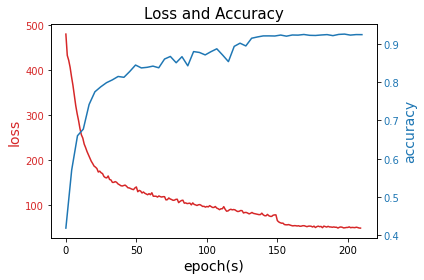

In [49]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ep = range(210)
ep2 = np.linspace(0, 210, 52)
color = 'tab:red'
ax1.set_xlabel('epoch(s)', fontsize = 14)
ax1.set_ylabel('loss', color=color, fontsize = 14)
ax1.plot(ep, loss_list[:210], color=color, label="loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Loss and Accuracy", fontsize = 15)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color, fontsize = 14)  # we already handled the x-label with ax1
ax2.plot(ep2, accuracy_list, color=color, label="accuracy")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("1.pdf")

In [69]:
correct = 0
for data in dataloader_test:
    input, output = data
    input, output = input.to(cnn.device), output.to(cnn.device)
    pred = cnn(input, train=False)
    pred = pred.argmax(dim=1)
    correct += torch.sum(pred == output.view(-1)).item()
print("Unseen entity pairs accuracy:", correct/15679)

Unseen entity pairs accuracy: 0.926462146820588


In [52]:
torch.save(cnn.state_dict(), "cnn_bg.pkl")

In [53]:
torch.sum(output.view(-1) == pred).item()

14495

In [70]:
pred[10000:10050], output[10000:10050]

(tensor([ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8, 20,  8,  8,  8,  8,  8,  8,  8,  8],
        device='cuda:0'),
 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
         8, 8], device='cuda:0'))

In [79]:
with open("result.txt", "w") as f:
    for kn, relation in zip(kn_database_unseen, pred.tolist()):
        line = id2entity[kn['h']] + '\t' + id2relation[relation].strip('\n') + '\t' + id2entity[kn['t']] + '\n'
        f.write(line)

In [55]:
from torchmetrics import F1Score
f1score = F1Score(21, average="macro").to(cnn.device)
f1score(pred, output)

tensor(0.7215, device='cuda:0')

给定一对实体，先挑出包含这些实体的所有句子，然后把句子用训练好的模型编码成张量然后输入分类器进行分类。